The goal of anomaly detection:
1. Internal use to debug (https://jira.corp.conviva.com/browse/CSR-4673)
2. Filter out those viewers so our metrics are not impacted by these (https://jira.corp.conviva.com/browse/CI-5620)

3 dimensions are used to detect anomaly viewers.

**Total Plays**: how many times did the user watch videos in one day<br>
**Total Play Minutes**: how long did the user watch videos in one day<br>
**Unique Assets**: how many assets did the user watch in one day


**Method 1: Anomaly detection algorithms**

plot 3-d scatter chart then apply one of the following algorithms(need to set a contamination rate as the input of the algorithms):
* Angle-based Outlier Detector (ABOD)
* Cluster-based Local Outlier Factor (CBLOF)
* Histogram-base Outlier Detection (HBOS)
* **Isolation Forest**
* K Nearest Neighbors (KNN)
* Average KNN
* Local Outlier Factor (LOF)
* Minimum Covariance Determinant (MCD)
* One-class SVM (OCSVM)
* Principal Component Analysis (PCA)
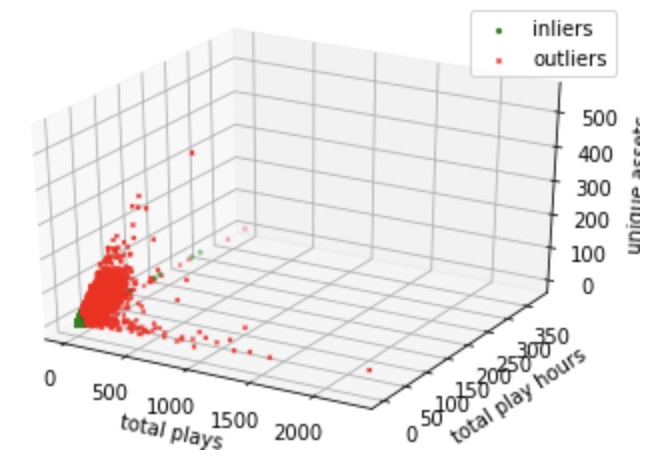


**Method 2: Threshold method** (simple and straightforward)<br>

Total Plays / Unique Assets > *threshold* 



**I will demo: <br>1) Isolation Forest algorithm <br>2) Threshold method**


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest

from google.cloud import bigquery
#from google.cloud import bigquery_storage_v1beta1


import ipywidgets as widgets
from IPython.display import display
from ipywidgets import GridspecLayout


import matplotlib 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Data preparation

In [3]:
set_input_table = widgets.Text(description='Input Table:', value='content-insights-prod-251102.echostar_slingtv.customer_view_by_uniqueid', disabled=False)
set_asset_id = widgets.Text(description='Asset ID:', value='asset_seriesName_showTitle', disabled=False)
set_viewer_id = widgets.Text(description='Viewer ID:', value='uniqueId', disabled=False)
set_date = widgets.DatePicker(
    description='Pick a Date',
    disabled=False
)

In [4]:
grid = GridspecLayout(2, 2)
grid[0, 0] = set_input_table
grid[0, 1] = set_asset_id
grid[1, 0] = set_viewer_id
grid[1, 1] = set_date
grid

GridspecLayout(children=(Text(value='content-insights-prod-251102.echostar_slingtv.customer_view_by_uniqueid',…

In [5]:
asset_id = set_asset_id.value
viewer_id = set_viewer_id.value
date = str(set_date.value)

input_table = set_input_table.value

print("asset id: {0} \nviewer id: {1} \ndate: {2} \ninput table: {3} ".format(asset_id, viewer_id, date, input_table))

asset id: asset_seriesName_showTitle 
viewer id: uniqueId 
date: 2020-06-21 
input table: content-insights-prod-251102.echostar_slingtv.customer_view_by_uniqueid 


connecting BigQuery

In [7]:
%env GOOGLE_APPLICATION_CREDENTIALS=/Users/adam/Documents/code/PycharmProjects/content-qa-dev-1.json

env: GOOGLE_APPLICATION_CREDENTIALS=/Users/adam/Documents/code/PycharmProjects/content-qa-dev-1.json


In [8]:
client = bigquery.Client()
# Perform a query.
QUERY = (
    'SELECT {0} uniqueId, count(1) total_plays, sum(session_playTimeMs) / 1000 / 60 total_playMins, count(distinct {1} ) unique_assets FROM `{2}` WHERE session_date = \"{3}\" Group by 1'.format(viewer_id, asset_id, input_table, date)
)
print(QUERY)
query_job = client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish

SELECT uniqueId uniqueId, count(1) total_plays, sum(session_playTimeMs) / 1000 / 60 total_playMins, count(distinct asset_seriesName_showTitle ) unique_assets FROM `content-insights-prod-251102.echostar_slingtv.customer_view_by_uniqueid` WHERE session_date = "2020-06-21" Group by 1


In [9]:
rowsdf = rows.to_dataframe()
rowsdf.head()

,uniqueId,total_plays,total_playMins,unique_assets
0,3368ec38-58a2-11e8-a17b-12a8f16ecbc2,38,1069.662333,28
1,354d2c9e-1994-11ea-beb6-0eed1eee55b5,139,1314.866333,55
2,b1910cc4-6c7a-11ea-ba30-12fa0a1cca97,54,1341.271233,50
3,8c061e7e-ec01-11e6-ab92-0eab275fdd4f,50,1409.581567,26
4,13f27396-90cc-11e6-8ead-120507c02073,43,1649.739433,39


In [22]:
#rowsdf.to_csv("./data/outlier_v3.csv")
readdf = pd.read_csv("./data/outlier_v3.csv")
rowsdf = readdf[readdf.columns[1:]]

# Isolation Forest Algorithm

In [24]:
set_contamination = widgets.FloatSlider(
    value=0.02,
    min=0.01,
    max=100,
    step=0.01,
    description='Outlier (%):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

In [32]:
grid = GridspecLayout(1, 1)
grid[0, 0] = set_contamination
grid

GridspecLayout(children=(FloatSlider(value=0.1, continuous_update=False, description='Outlier (%):', layout=La…

In [33]:
contamination = set_contamination.value / 100
print("contamination rate:{0} ".format(contamination))

contamination rate:0.001 


In [34]:
iforestdf = rowsdf.copy()
to_model_columns=iforestdf.columns[1:4]
to_model_columns

clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=contamination, \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(iforestdf[to_model_columns])
pred = clf.predict(iforestdf[to_model_columns])
iforestdf['anomaly']=pred
outliers=iforestdf.loc[iforestdf['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(iforestdf['anomaly'].value_counts())

 1    1403954
-1       1381
Name: anomaly, dtype: int64


In [35]:
iforestdf.head()

,uniqueId,total_plays,total_playMins,unique_assets,anomaly
0,3368ec38-58a2-11e8-a17b-12a8f16ecbc2,38,1069.662333,28,1
1,354d2c9e-1994-11ea-beb6-0eed1eee55b5,139,1314.866333,55,1
2,b1910cc4-6c7a-11ea-ba30-12fa0a1cca97,54,1341.271233,50,1
3,8c061e7e-ec01-11e6-ab92-0eab275fdd4f,50,1409.581567,26,1
4,13f27396-90cc-11e6-8ead-120507c02073,43,1649.739433,39,1


In [36]:
iforestdf[iforestdf['anomaly'] == -1].head()

,uniqueId,total_plays,total_playMins,unique_assets,anomaly
69,b74543d2-89b3-11ea-8c7c-1201ac454357,276,784.364717,143,-1
214,920a3258-eede-11e6-a14f-0ef78a713d4b,102,2172.056083,54,-1
416,73f3d670-b97a-11e9-a622-0ae4d22fb3fe,170,2229.381533,57,-1
447,6dfdc006-3eae-11e9-924a-12e24c2e6ffe,302,785.568617,60,-1
510,7aa733c2-c37b-11e8-8b6a-126dabf4816c,122,1640.808900,61,-1


In [40]:
iforestdf[iforestdf['anomaly'] == -1].sort_values(by='total_playMins', ascending=False)

,uniqueId,total_plays,total_playMins,unique_assets,anomaly
38382,2089f72c-f754-11e9-b4b8-1230fab23a74,210,4367.279100,84,-1
13351,54acca72-7670-11e8-baed-129ca5e83d02,83,3905.554150,73,-1
7710,96987520-b5c4-11e7-8dd0-0a1384f1149e,153,3901.003300,110,-1
27240,8ad9684c-5fcf-11e8-ba25-122220e4686c,196,3870.034467,120,-1
91777,b9698b66-d6d5-11e7-b331-0eab56b32b92,81,3849.113433,69,-1
...,...,...,...,...,...
14845,02bc29c4-a45e-11ea-abba-12d5678f9ff7,155,115.050617,57,-1
60765,6de73030-4c14-11e8-af98-0a7c177c24fa,144,92.078133,121,-1
65049,c02e2436-fcc5-11e8-b192-0ac514857952,139,82.478200,134,-1
8557,0b25fbf6-ad8f-11e9-ae69-0e70f37783e6,155,54.619083,73,-1


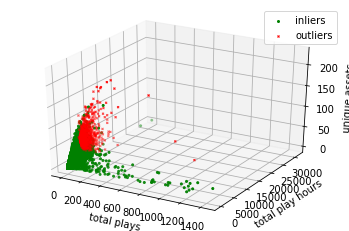

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#normalize the metrics
outliers = iforestdf[iforestdf['anomaly'] == -1][to_model_columns]
inliers = iforestdf[iforestdf['anomaly'] == 1][to_model_columns]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("total plays")
ax.set_ylabel("total play hours")
ax.set_zlabel("unique assets")
# Plot the compressed data points
ax.scatter(inliers['total_plays'], inliers['total_playMins'], inliers['unique_assets'], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(outliers['total_plays'], outliers['total_playMins'],outliers['unique_assets'], s=4, lw=1, label="outliers",c="red", marker="x")

ax.legend()
plt.show()

# Threshold method

In [38]:
set_threshold = widgets.FloatSlider(
    value=50,
    min=1,
    max=100,
    step=1,
    description='Threshold:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)

In [39]:
grid = GridspecLayout(1, 1)
grid[0, 0] = set_threshold
grid

GridspecLayout(children=(FloatSlider(value=50.0, continuous_update=False, description='Threshold:', layout=Lay…

In [61]:
threshold = set_threshold.value
print("plays per asset threshold:{0} ".format(threshold))

plays per asset threshold:30.0 


In [62]:
thresholddf = rowsdf.copy()
to_model_columns=iforestdf.columns[1:4]
to_model_columns

thresholddf['anomaly'] = np.where(thresholddf['total_plays']/thresholddf['unique_assets']>threshold, -1, 1)

print(thresholddf['anomaly'].value_counts())

 1    1405243
-1         92
Name: anomaly, dtype: int64


In [63]:
thresholddf.head()

,uniqueId,total_plays,total_playMins,unique_assets,anomaly
0,3368ec38-58a2-11e8-a17b-12a8f16ecbc2,38,1069.662333,28,1
1,354d2c9e-1994-11ea-beb6-0eed1eee55b5,139,1314.866333,55,1
2,b1910cc4-6c7a-11ea-ba30-12fa0a1cca97,54,1341.271233,50,1
3,8c061e7e-ec01-11e6-ab92-0eab275fdd4f,50,1409.581567,26,1
4,13f27396-90cc-11e6-8ead-120507c02073,43,1649.739433,39,1


In [64]:
thresholddf[thresholddf['anomaly'] == -1].head()

,uniqueId,total_plays,total_playMins,unique_assets,anomaly
19,b4b8085a-0c10-11ea-8f00-0a9e4af6647b,849,388.280633,6,-1
366,715fa5fa-094a-11e9-87af-12551342edba,423,223.228183,6,-1
1602,d9f5c16e-94a5-11e7-b8f3-12d8ce9c8723,1029,410.480867,14,-1
1718,5b7d7434-568c-11ea-9075-0a9881e8d5e1,241,71.716450,4,-1
2419,5b7e0218-6925-11ea-807e-0e4c31652fed,336,31.726583,1,-1


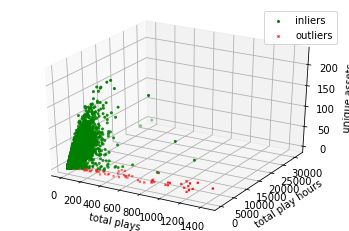

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#normalize the metrics
outliers = thresholddf[thresholddf['anomaly'] == -1][to_model_columns]
inliers = thresholddf[thresholddf['anomaly'] == 1][to_model_columns]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("total plays")
ax.set_ylabel("total play hours")
ax.set_zlabel("unique assets")
# Plot the compressed data points
ax.scatter(inliers['total_plays'], inliers['total_playMins'], inliers['unique_assets'], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(outliers['total_plays'], outliers['total_playMins'],outliers['unique_assets'], s=4, lw=1, label="outliers",c="red", marker="x")

ax.legend()
plt.show()

# 10 different clustering algorithms 

* Angle-based Outlier Detector (ABOD)
* Cluster-based Local Outlier Factor (CBLOF)
* Histogram-base Outlier Detection (HBOS)
* Isolation Forest
* K Nearest Neighbors (KNN)
* Average KNN
* Local Outlier Factor (LOF)
* Minimum Covariance Determinant (MCD)
* One-class SVM (OCSVM)
* Principal Component Analysis (PCA)

In [78]:
from scipy import stats
# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP

from sklearn.preprocessing import MinMaxScaler

In [106]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.03
# Define seven outlier detection tools to be compared
classifiers = {
     #   'Angle-based Outlier Detector (ABOD)':
     #   ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    #'Feature Bagging':
    #    FeatureBagging(LOF(n_neighbors=35),
    #                   contamination=outliers_fraction,
    #                   random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state)
}

In [103]:
def plot_outlier(df, f1, f2, fraction):
    outliers_fraction = fraction
    scaler = MinMaxScaler(feature_range=(0, 1))
    df[[f1, f2]] = scaler.fit_transform(df[[f1, f2]])
    X1 = df[f1].values.reshape(-1,1)
    X2 = df[f2].values.reshape(-1,1)

    X = np.concatenate((X1,X2),axis=1)
    
    xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1
            
        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)
        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)
        plt.figure(figsize=(10, 10))
        
        # copy of dataframe
        dfx = df
        dfx['outlier'] = y_pred.tolist()
        
        # IX1 - inlier feature 1,  IX2 - inlier feature 2
        IX1 =  np.array(dfx[f1][dfx['outlier'] == 0]).reshape(-1,1)
        IX2 =  np.array(dfx[f2][dfx['outlier'] == 0]).reshape(-1,1)
        
        # OX1 - outlier feature 1, OX2 - outlier feature 2
        OX1 =  dfx[f1][dfx['outlier'] == 1].values.reshape(-1,1)
        OX2 =  dfx[f2][dfx['outlier'] == 1].values.reshape(-1,1)
             
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
            
        # threshold value to consider a datapoint inlier or outlier
        threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
            
        # decision function calculates the raw anomaly score for every point
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
              
        # fill blue map colormap from minimum anomaly score to threshold value
        plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
            
        # draw red contour line where anomaly score is equal to thresold
        a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
            
        # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
        plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
            
        b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
        
        c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
           
        plt.axis('tight')  
        
        # loc=2 is used for the top left corner 
        plt.legend(
            [a.collections[0], b,c],
            ['learned decision function', 'inliers','outliers'],
            prop=matplotlib.font_manager.FontProperties(size=20),
            loc=2)
          
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.title(clf_name)
        plt.show()

OUTLIERS :  150 INLIERS :  4850 Cluster-based Local Outlier Factor (CBLOF)


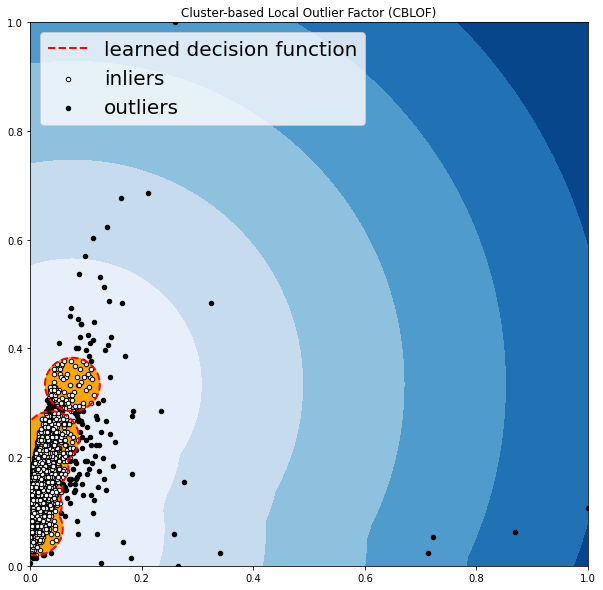

OUTLIERS :  147 INLIERS :  4853 Histogram-base Outlier Detection (HBOS)


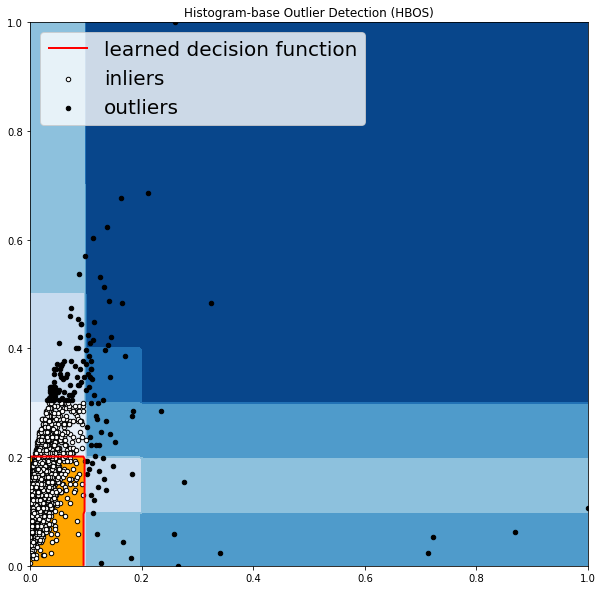

OUTLIERS :  150 INLIERS :  4850 Isolation Forest


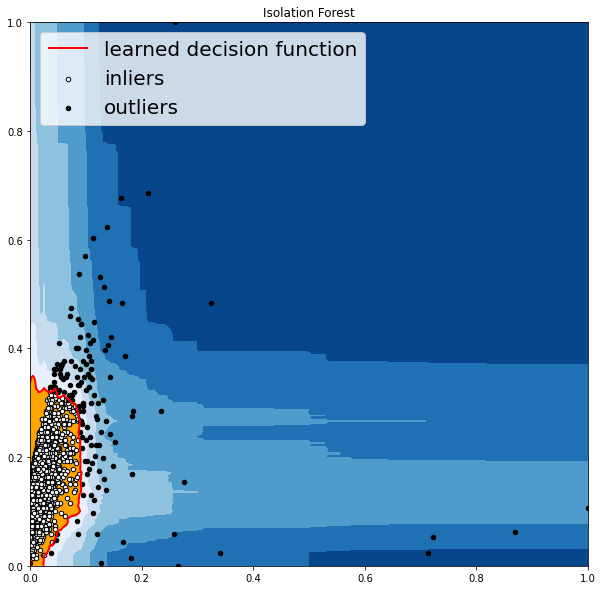

OUTLIERS :  136 INLIERS :  4864 K Nearest Neighbors (KNN)


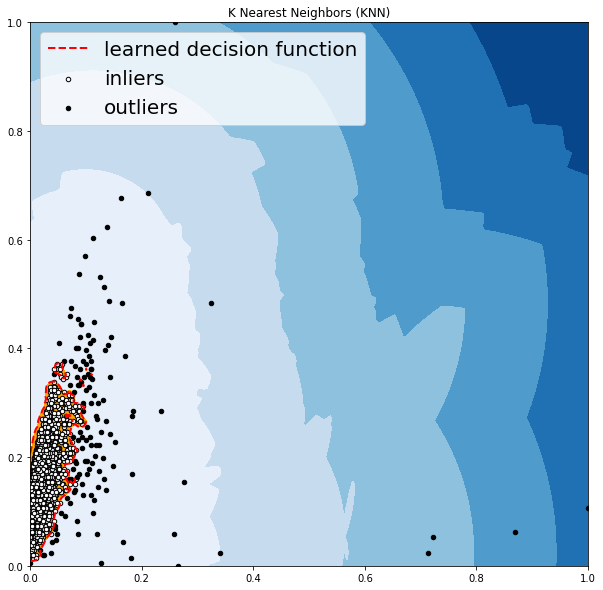

OUTLIERS :  103 INLIERS :  4897 Average KNN


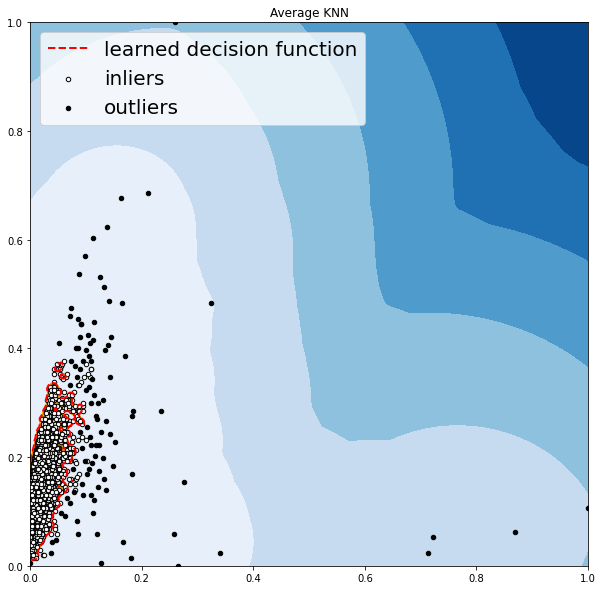

OUTLIERS :  135 INLIERS :  4865 Local Outlier Factor (LOF)


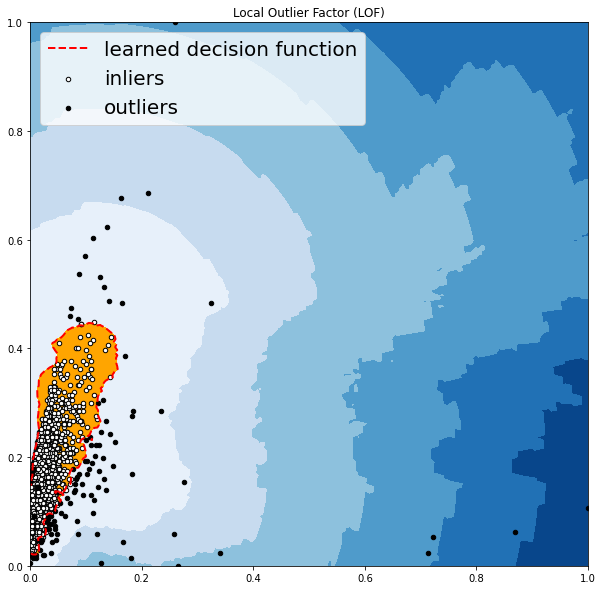

OUTLIERS :  150 INLIERS :  4850 Minimum Covariance Determinant (MCD)


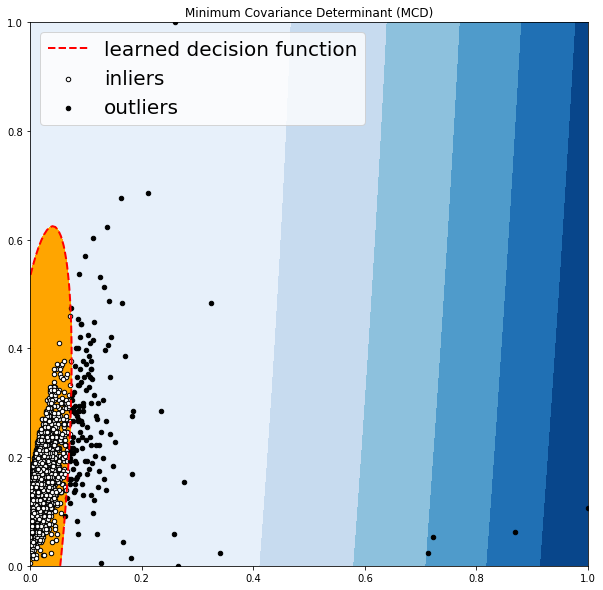

OUTLIERS :  150 INLIERS :  4850 One-class SVM (OCSVM)


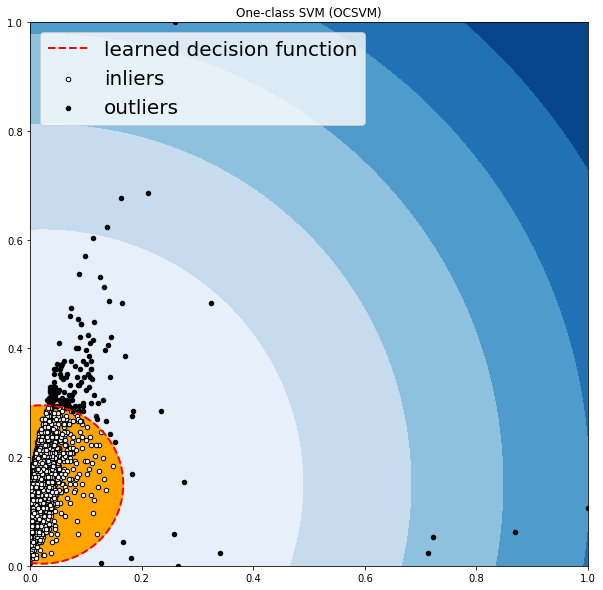

OUTLIERS :  150 INLIERS :  4850 Principal Component Analysis (PCA)


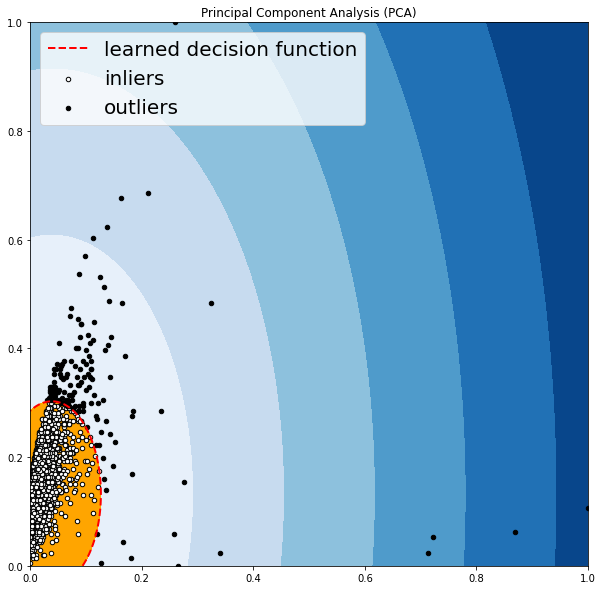

In [107]:
plot_outlier(rowsdf[0:5000], 'total_plays', 'unique_assets', 0.03) 